In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.metrics import r2_score

# Step 1: Load the data
df = pd.read_csv(r'C:\Users\jayka\Downloads\AI Space\Final_Project\Auto Sales data.csv')

# Step 2: Preprocess the data
# Convert 'ORDERDATE' to datetime format
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

# Aggregate the data by week, summing the SALES for each week
df['week'] = df['ORDERDATE'].dt.to_period('W').dt.start_time
weekly_sales = df.groupby('week')['SALES'].sum().reset_index()

# Rename the columns for Prophet: 'ds' for date and 'y' for sales (target variable)
weekly_sales.rename(columns={'week': 'ds', 'SALES': 'y'}, inplace=True)





# Step 3: Create lag features and rolling statistics
# Create lag features (1-week lag, 2-week lag, etc.)
weekly_sales['y_lag1'] = weekly_sales['y'].shift(1)  # 1-week lag
weekly_sales['y_lag2'] = weekly_sales['y'].shift(2)  # 2-week lag

# Fill NaN values generated by lagging with 0 (or any other suitable method)
weekly_sales['y_lag1'].fillna(0, inplace=True)
weekly_sales['y_lag2'].fillna(0, inplace=True)

weekly_sales['y_lag1'].head()

# Create rolling statistics (4-week rolling mean)
weekly_sales['y_rolling_mean'] = weekly_sales['y'].rolling(window=4).mean()

# Fill NaN values generated by rolling statistics
weekly_sales['y_rolling_mean'].fillna(0, inplace=True)

# Optional: Drop any rows with NaN values (if any) caused by other operations
weekly_sales.dropna(inplace=True)

# Step 4: Ensure continuous date range (fill in missing weeks)
# Create a continuous date range from the minimum to maximum week in the dataset
full_date_range = pd.date_range(start=weekly_sales['ds'].min(), end=weekly_sales['ds'].max(), freq='W-Mon')

# Merge the full date range with the existing sales data to include missing weeks
# Missing weeks will have NaN for sales
weekly_sales_full = pd.DataFrame({'ds': full_date_range})
weekly_sales_full = pd.merge(weekly_sales_full, weekly_sales, on='ds', how='left')


Q1 = weekly_sales_full.quantile(0.20)
Q3 = weekly_sales_full.quantile(0.80)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

weekly_sales_full = weekly_sales_full.clip(lower=lower_bound, upper=upper_bound, axis=1)


# Step 5: Fill missing values for sales (if any)
weekly_sales_full['y'].fillna(0, inplace=True)
weekly_sales_full['y_lag1'].fillna(0, inplace=True)
weekly_sales_full['y_lag2'].fillna(0, inplace=True)
weekly_sales_full['y_rolling_mean'].fillna(0, inplace=True)



C:\Users\jayka\AppData\Local\Temp\ipykernel_9020\2867595520.py:13: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
C:\Users\jayka\AppData\Local\Temp\ipykernel_9020\2867595520.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weekly_sales['y_lag1'].fillna(0, inplace=True)
C:\Users\jayka\AppData\Local\Temp\ipykernel_9020\2867595520.py:33: FutureWarning: A value is

19:30:12 - cmdstanpy - INFO - Chain [1] start processing
19:30:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jayka\AppData\Local\Temp\ipykernel_9020\3874691296.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_dates[['y_lag1', 'y_lag2', 'y_rolling_mean']] = future_dates[['y_lag1', 'y_lag2', 'y_rolling_mean']].fillna(method='ffill')


          ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2018-01-01  23792.487451 -61893.556896  23274.506645  23792.487451   
1 2018-01-08  24122.409692 -53306.352127  33131.376223  24122.409692   
2 2018-01-15  24452.331933 -35557.688303  49156.466182  24452.331933   
3 2018-01-22  24782.254174 -29165.951098  57659.019942  24782.254174   
4 2018-01-29  25112.176415 -36331.292933  49450.403676  25112.176415   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  23792.487451   -42749.706294         -42749.706294         -42749.706294   
1  24122.409692   -34284.607491         -34284.607491         -34284.607491   
2  24452.331933   -16845.826392         -16845.826392         -16845.826392   
3  24782.254174    -8828.306733          -8828.306733          -8828.306733   
4  25112.176415   -18996.117207         -18996.117207         -18996.117207   

   extra_regressors_additive  ...  y_rolling_mean  y_rolling_mean_lower  \
0              -3

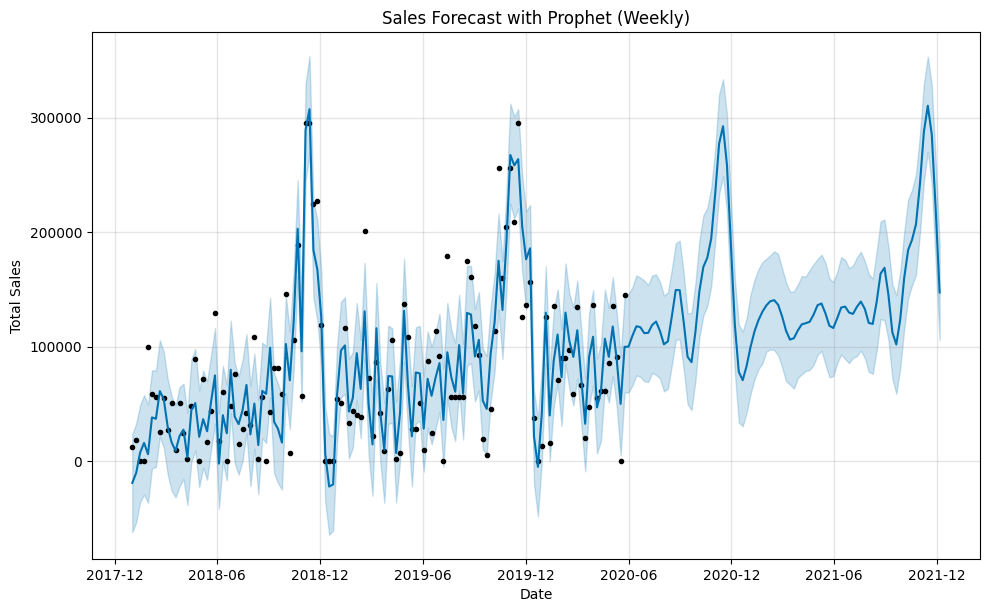

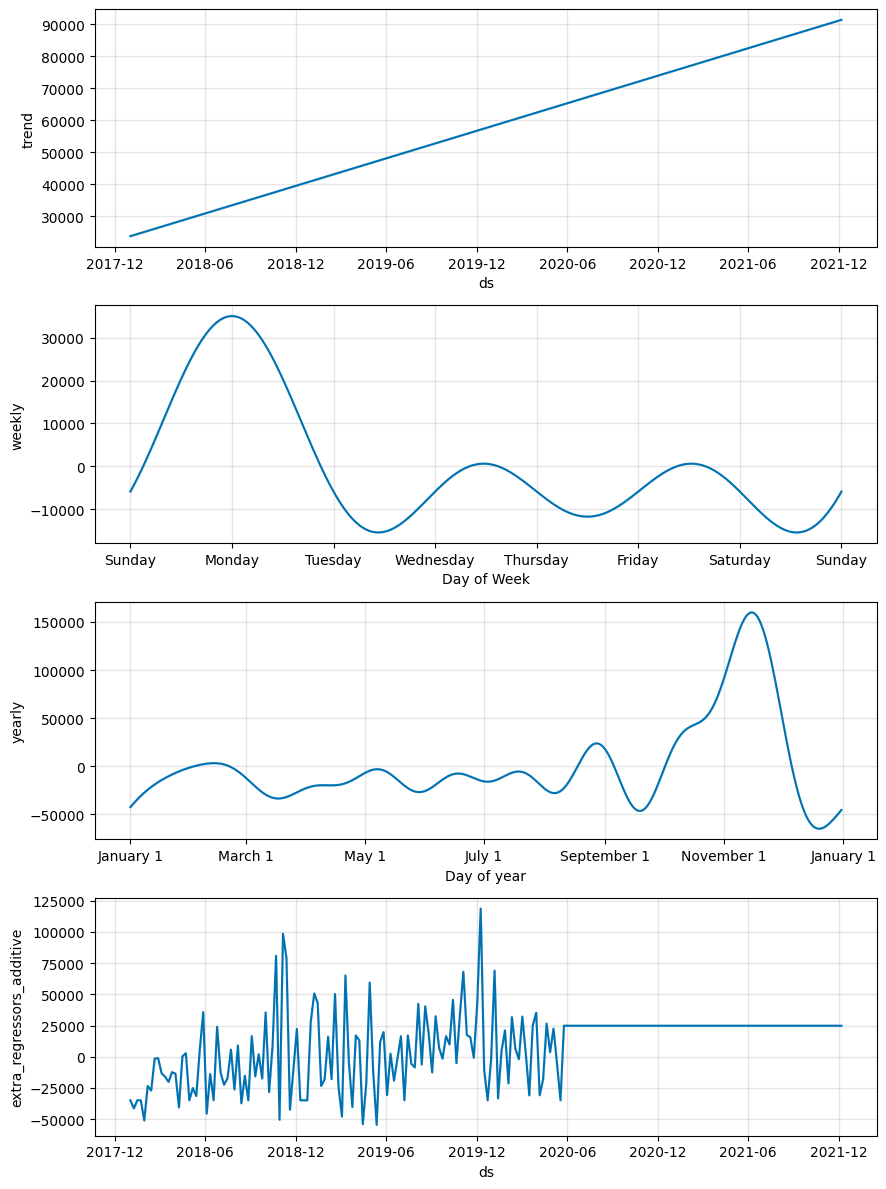

            ds           yhat     yhat_lower     yhat_upper
201 2021-11-08  287476.540737  244050.758992  329490.151215
202 2021-11-15  310293.721113  270224.325337  353225.048378
203 2021-11-22  285324.648368  241929.749631  327949.007609
204 2021-11-29  219824.226861  173752.104374  262109.657906
205 2021-12-06  147300.585963  105352.998540  188592.710371


In [3]:

# Step 6: Initialize the Prophet Model
# Include lag and rolling features as regressors in the model
model = Prophet(weekly_seasonality=True, seasonality_prior_scale=10.0, changepoint_prior_scale=0.01)

# Add regressors for lag features and rolling statistics
model.add_regressor('y_lag1')
model.add_regressor('y_lag2')
model.add_regressor('y_rolling_mean')

# Step 7: Fit the model to your data
model.fit(weekly_sales_full)

# Step 8: Create future dates for prediction
# Generate future dates for the next 180 days (this will be in weekly intervals)
future_dates = model.make_future_dataframe(periods=80, freq='W-Mon')

# Merge the future dates with the existing data to include lag and rolling features
# For the future data, we'll fill the lag and rolling features with the most recent available values
future_dates = pd.merge(future_dates, weekly_sales_full[['ds', 'y_lag1', 'y_lag2', 'y_rolling_mean']], on='ds', how='left')

future_dates[['y_lag1', 'y_lag2', 'y_rolling_mean']] = future_dates[['y_lag1', 'y_lag2', 'y_rolling_mean']].fillna(method='ffill')


# Step 9: Predict the future sales
forecast = model.predict(future_dates)
print(forecast.head())

# Step 10: Merge the forecast with actual values for accuracy calculation
merged_data = pd.merge(weekly_sales_full, forecast[['ds', 'yhat']], on='ds', how='inner')

# Calculate accuracy metrics
mae = mean_absolute_error(merged_data['y'], merged_data['yhat'])
mse = mean_squared_error(merged_data['y'], merged_data['yhat'])
rmse = mse**0.5
mape = (abs((merged_data['y'] - merged_data['yhat']) / merged_data['y']).replace([float('inf'), -float('inf')], 0).mean()) * 100
r2 = r2_score(merged_data['y'], merged_data['yhat'])


# Print the accuracy metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"R2 Score : {r2}")

# Step 11: Visualize the results
# Plot the forecast
model.plot(forecast)
plt.title('Sales Forecast with Prophet (Weekly)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

# Step 12: Visualize the forecast components (Trend, Seasonality)
model.plot_components(forecast)
plt.show()

# Optional: Save the forecast data (including forecasted values)
forecast_data = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]  # Extract the relevant columns
forecast_data.to_csv('weekly_sales_forecast.csv', index=False)

# Show the forecasted data (optional)
print(forecast_data.tail())  # View the last rows of the forecasted data
